# Fashion Image Captioner

This notebook finetunes a general visual language model (VLM) that can caption images to be able to generate more specific search-relevant descriptions of images from thrifted fashioin item inventories

# Prepare Environment

In [1]:
#Install packages needed first time in Environment
if False:
    !pip install pandas
    !pip install scikit-learn
    !pip install torch torchvision
    !pip install transformers
    !pip install datasets #Hugging Face
    !pip install tqdm
    !pip install Pillow
    !pip install peft
    !pip install rouge_score
    !pip install evaluate

In [2]:
#Import Libraries

#General
import os
import gc

#Standard ML
from pandas import read_csv
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

#Data Visualization
from torchvision.transforms import ToPILImage
from PIL import Image as pilImage
from IPython.display import display

#HuggingFace Libraries
from datasets import Dataset as hfDataset
from datasets import Image
from accelerate import Accelerator

#The Model
from transformers import Blip2ForConditionalGeneration #visual language model (VLM) can do multimodal tasks like captioning or answering questions about images.
from transformers import Blip2Processor

#Extras
from tqdm import tqdm #cute loading percent bar


In [3]:
# Check GPU Availability
# Device will be reset automatically later by accelerator, but this is a good sanity check to know what we should be working with

# Check for MPS availability
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple's MPS
    print(f"Using torch version {torch.__version__}")
    print("Found MPS is available for use") # Is MPS even available? macOS 12.3+
    print(f"Current version on Pytorch was built with MPS activation: {torch.backends.mps.is_built()}") # Was the current version of PyTorch built with MPS activated?
elif torch.cuda.is_available():
    device = torch.device("cuda")
    nGPUs = torch.cuda.device_count()
    print(f"Found {nGPUs} cuda GPUs available for use")
else:
    device = torch.device("cpu")
    print("No GPU device found, running on cpu")

Found 4 cuda GPUs available for use


# Import Data

To use as-is, a root project folder should contain
* a subproject folder containing this notebook (can have any name)
* a data folder, called Data, containing
  *  DB_FILENAME: a csv file with at least two columns
     *   IMAGE_PATH_COL: contains image names
     *   CAPTION_COL: contains image cpations
  * IMAGE_FOLDERNAME: A folder containing images with the names referenced in IMAGE_PATH_COL
 
The logic for this sturcture is that there can be multiple subprojects that need to access the same dataset

In [4]:
#SET IMAGE LOCATION INFO

#Specify Data Locations
CSV_FILENAME_g = 'items_captions_150.csv' #'ThredupData.csv'
CAPTION_COL_g = "description"
IMAGE_PATH_COL_g = "filename"
IMAGE_FOLDERNAME_g = 'StanfordJpegs'

DATA_FOLDER_g = os.path.join('..', 'Data') #'..' means the folder one up from current notebook's folder, which happens to be where I have my data folder
IMAGE_FOLDER_g = os.path.join(DATA_FOLDER_g, IMAGE_FOLDERNAME_g)
CSV_FILEPATH_g = os.path.join(DATA_FOLDER_g, CSV_FILENAME_g)

In [5]:
#IMPORT RAW DATA TO DATAFRAME

def getDatasetDF(csv_filepath = CSV_FILEPATH_g, image_folder = IMAGE_FOLDER_g):
    
    """
    Create dataframe based on csv file
    returns data_df which has infomration to eventually create two columns: captions (string descriptions of images) and images (paths to image files) and c
    """
    
    if len(csv_filepath) == 0:
        return
    data_df = read_csv(csv_filepath)
    
    return data_df # Should have 
    

data_df_g = getDatasetDF()
data_df_g.head()

,filename,description
0,item108153495.jpg,This is a burgundy women's blouse featuring a ...
1,item112414117.jpg,The item is a classic black suede pump featuri...
2,item112851743.jpg,These are women's coral pink straight-leg capr...
3,item111933518.jpg,This is a black suede peep-toe ankle boot feat...
4,item110548869.jpg,"The item is a pair of straight-leg, red pants ..."


In [6]:
#Optionally manually edit dataframe to explore effect of individual changes

changeDataManually_g = False

def changeRows(data_df = data_df_g, colToChange = CAPTION_COL_g):
    colToChange = "Captions"
    changeDict = {
        846: "a black ankleboot with fringe detailing on the side",
        4815: "a yellow beanie on a white background",
        5093: "a cage-style heel with floral print",
        2835: "a black leather heeled boot with a pointed toe"   
        }
    
    for itemId, content in changeDict.items():
        data_df.loc[itemId,colToChange] = content

    return data_df

if changeDataManually_g:
    data_df_g = changeRows()
    data_df_g.head()
else:
    print("No manual changes made to data.")


No manual changes made to data.


In [7]:
#FILTER DATAFRAME TO JUST DESIRED CONTENT

def imagePathColCreator(data_df, image_folder, image_path_col):
    #image_paths = list(os.path.join(image_folder,('item'+str(fileId))) for fileId in data_df["Item_Id"]) #From original ThredupData.csv Use ItemId column to create list of paths to image files
    image_paths = list(os.path.join(image_folder,filePath)[:-4] for filePath in data_df[image_path_col]); #From Esra's LLM generated caption dataset The -4 is to get rid of .jpg in spreadhseet's filenames since filenames in data folder don't currently have these file endings
    return image_paths

def captionColCreator(data_df, caption_col):
    #captions = list(data_df["Category_Type"] + ", " + data_df["Description"]) #If using original ThredupData.csv, use Description column to create list of captions for each image  
    captions = data_df[caption_col] #From Esra's LLM generated caption dataset The -4 is to get rid of .jpg in spreadhseet's filenames since filenames in data folder don't currently have these file endings
    return captions

def createImageAndCaptionDf(data_df = data_df_g, image_folder = IMAGE_FOLDER_g, image_path_col= IMAGE_PATH_COL_g, caption_col = CAPTION_COL_g ):

    #Create image paths
    data_df["image_paths"] = imagePathColCreator(data_df, image_folder, image_path_col)

    #Create caption paths
    data_df["captions"] = captionColCreator(data_df, caption_col)
     
    #Discard rows without valid image paths
    print(f"Original samples in dataframe: {len(data_df)}")
    valid_rows = [ind for ind, image_path in enumerate(data_df["image_paths"]) if os.path.exists(image_path)] #Get rid of any image paths that do not point to actual image files
    data_df = data_df.iloc[valid_rows]
    print(f"Samples with valid image paths in dataframe: {len(data_df)}")

    #Discard all other columns
    data_df = data_df[["captions", "image_paths"]]

    return data_df

data_df_g = createImageAndCaptionDf()

data_df_g.head()
    

Original samples in dataframe: 151
Samples with valid image paths in dataframe: 130


,captions,image_paths
0,This is a burgundy women's blouse featuring a ...,../Data/StanfordJpegs/item108153495
1,The item is a classic black suede pump featuri...,../Data/StanfordJpegs/item112414117
2,These are women's coral pink straight-leg capr...,../Data/StanfordJpegs/item112851743
3,This is a black suede peep-toe ankle boot feat...,../Data/StanfordJpegs/item111933518
4,"The item is a pair of straight-leg, red pants ...",../Data/StanfordJpegs/item110548869


# Select Train/Valid/Test Datasets

In [8]:
#Training Toggles

VALIDATION_PORTION_g = 0.2
TEST_PORTION_g = .1
SEED_g = 22

# Split off training data
train_df_g, test_and_validation_df_g = train_test_split(data_df_g, test_size=(VALIDATION_PORTION_g + TEST_PORTION_g), random_state=SEED_g)

#Split remaining into validation and test dats
validation_df_g, test_df_g = train_test_split(test_and_validation_df_g, test_size=TEST_PORTION_g, random_state=SEED_g)

print(f"""
Train Size: {len(train_df_g)},
Validation Size: {len(validation_df_g)},
Test Size: {len(test_df_g)} 
""")
train_df_g.head()


Train Size: 90,
Validation Size: 36,
Test Size: 4 



,captions,image_paths
141,"This is a contemporary, maroon-colored, long-s...",../Data/StanfordJpegs/item112152515
91,"This is a contemporary, dark purple, lightweig...",../Data/StanfordJpegs/item91790911
112,"This is a long-sleeved, deep plum-colored blou...",../Data/StanfordJpegs/item110766567
128,This is a classic black leather Chelsea boot f...,../Data/StanfordJpegs/item109803463
29,"This is a long-sleeve, burgundy-colored blouse...",../Data/StanfordJpegs/item111237588


# Create Hugging Face Datasets


In [9]:
#Create train, valid, test huggingface datasets

def createHuggingfaceDataset(data_df):
    image_paths = list(data_df["image_paths"])
    captions = list(data_df["captions"])
    dataframe_indices = data_df.index.tolist()
    
    #Create HuggingFace Dataset from python dict containing two lists, image paths and captions
    dataset_hf = hfDataset.from_dict(
                                {
                                    "image": image_paths,
                                    "text": captions,
                                    "df_ind": dataframe_indices
                                }
                            )
    dataset_hf = dataset_hf.cast_column("image", Image()) #Cast the image column to image data type so can be linked files can be accessed as images

    #Delete variables to free up memory (may not be necessary)
    del [image_paths, captions, data_df, dataframe_indices]
    gc.collect() #collect garbage 
    
    return dataset_hf

train_hfset_g = createHuggingfaceDataset(train_df_g)
print("training hugging face dataset created")

validation_hfset_g = createHuggingfaceDataset(validation_df_g)
print("validation hugging face dataset created")

test_hfset_g = createHuggingfaceDataset(test_df_g)
print("test hugging face dataset created")

training hugging face dataset created
validation hugging face dataset created
test hugging face dataset created


# View Examples

HUGGING FACE IMAGE:


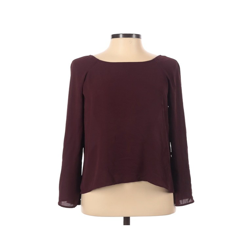

HUGGING FACE CAPTION:
This is a contemporary, maroon-colored, long-sleeve blouse made from a smooth, likely synthetic fabric, featuring a regular fit with a slightly flaring hem and understated cuffs, suitable for casual to business-casual wear.

ORIGINAL DF INFO:
captions       This is a contemporary, maroon-colored, long-s...
image_paths                  ../Data/StanfordJpegs/item112152515
Name: 141, dtype: object


In [10]:
#Select image to view huggingface and original dataframe data

hfset_to_view_g = train_hfset_g
hf_ind_to_view_g=0 #index of image to look at
corresponding_dataframe_g = train_df_g

def displayImage(hf_ind = hf_ind_to_view_g, hfset = hfset_to_view_g, corresponding_dataframe = corresponding_dataframe_g):
    #hf image
    image = hfset[hf_ind]["image"].resize((252,252))
    print("HUGGING FACE IMAGE:")
    display(image)
    
    #hf caption
    print(f'HUGGING FACE CAPTION:\n{hfset[hf_ind]["text"]}\n')
    
    #original dataframe info
    orig_df_ind = hfset[hf_ind]["df_ind"]
    print(f'ORIGINAL DF INFO:\n{corresponding_dataframe.loc[orig_df_ind]}')

displayImage()

# Import Datasets to Dataloaders

In [11]:
#Create Pytorch Dataset Class for input o Dataloaders

class ImageCaptioningDataset(Dataset): #this class inherits functionalities and structure of the pytorch Dataset class
    
    def __init__(self, huggingFaceDataset, processor):       
        self.dataset = huggingFaceDataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        item = self.dataset[idx] #each item in self.dataset has an image and text
        
        #process image (returns a dictionary with a single item containing the processed image)
        encoding = self.processor(images = item["image"], #get image
                                  #.resize(self.new_size), #resize
                                  #padding = "max_length", #set padding
                                  return_tensors = "pt" #return as pytorch tensor dtype
                                 )
        
        # remove batch dimension
        encoding = {key: value.squeeze() for key, value in encoding.items()} #

        #add text info
        encoding["text"] = item["text"]

        # Include the original index (from hugging face) in the returned data
        encoding['hf_idx'] = idx
        
        return encoding

    def get_original_image(self, idx):
        #This method gets the original image from the Hugging Face dataset for a given index.
        return self.dataset[idx]["image"]



In [12]:
#Create Processor which does image and caption pre-processing
# (used in creation of pytorch dataset and collate functions)

def getProcessor():
    pretraining = 'Salesforce/blip2-opt-2.7b'
    processor = Blip2Processor.from_pretrained(pretraining)
    return processor

processor_g = getProcessor()

In [13]:
def collate_fn(batch, processor = processor_g):

    #batch is a list of examples (dictionaries), where each example has the same keys (image and text)
    
    # pad the tokenized_captions and attention_mask
    processed_batch = {}
    
    item_keys = batch[0].keys()
    
    for key in item_keys: #only have to iterate over keys from first example in batch, bc all examples have same keys
        if key == "pixel_values":
            processed_batch[key] = torch.stack([item[key] for item in batch]) #stack images from all examples in batch
        elif key == "text":
            #tokenize the caption (ie break up caption into chunks and convert each chunk to a number using look up table)
            text_inputs = processor.tokenizer(
                                            [item["text"] for item in batch], 
                                            padding = "max_length" ,#True, 
                                            max_length = 50, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["tokenized_captions"] = text_inputs["input_ids"] #input_ids is conventionally used in the Hugging Face Transformers library and other NLP frameworks to refer to the tokenized representation of text inputs. This naming convention is primarily for consistency and clarity within the context of language models and their input processing
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
        elif key == "hf_idx":
            processed_batch[key] = [item[key] for item in batch]
        else:
            print(f"{key} KEY NOT ACOUNTED FOR !!")
    
    return processed_batch

In [14]:
#CREATE PYTORCH DATA LOADERS

BATCH_SIZE_g = 16 #(32+ Too Big on my Vast.AI instance) #56 #64 #128 #512 #1024
processor_g = getProcessor()

train_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(train_hfset_g, processor_g), 
                              shuffle = True, 
                              batch_size = BATCH_SIZE_g, 
                              collate_fn = collate_fn,
                             )

validation_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(validation_hfset_g, processor_g), 
                               batch_size = BATCH_SIZE_g, 
                               collate_fn = collate_fn,
                              )

test_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(validation_hfset_g, processor_g), 
                               batch_size = BATCH_SIZE_g, 
                               collate_fn = collate_fn,
                              )

# del train_hfset

# Get Model

In [15]:
# LOAD MODEL
model_g = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", 
                                                      torch_dtype = torch.float32
                                                     )

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [16]:
# LOAD LoRA CONFIG

from peft import LoraConfig, get_peft_model   
    
config_g = LoraConfig(
    r = 10, #32, #10, #18, #16, # Rank size determined number of trainable parameters.
    lora_alpha = 32, # scaling factor sets magnitude LoRA updates have on the original weights
    lora_dropout = 0.05, #percent of cells not enabled at any time
    bias = "none",
    target_modules = ["q_proj", "k_proj"] #focus model's adaptation on the attention mechanism
)

model_g = get_peft_model(model_g, config_g) #peft model is the hugging face name for their library that uses LORA "parameter efficient fine-tuning"
    
model_g.print_trainable_parameters()

trainable params: 3,276,800 || all params: 3,747,956,736 || trainable%: 0.08742897079162015


In [17]:
# OPTIMIZER
lr_g = 1e-4 #2e-4 #5e-4 #8e-4
optimizer_g = torch.optim.Adam(model_g.parameters(), lr = lr_g)

In [18]:
# ACCELERATOR
# optimizes training and evaluation loops for the available hardware in a device agnostic way,
# eliminating need to use .to(device) or wrap model with torch.nn.DataParallel for multi-GPU training

accelerator_g = Accelerator() #hugging face optimization handles device placement and optimizes training speed
model_g, optimizer_g, train_dataloader_g, validation_dataloader_g  = accelerator_g.prepare(model_g, optimizer_g, train_dataloader_g, validation_dataloader_g)

device_g = accelerator_g.device
print(f'Device: {device_g}')


Device: cuda


# Get Before Examples to Compare Against After Fine-tuning

In [19]:
#SUBFUNCTIONS TO COMPARE LABELS, UNTUNED AND TUNED CAPTIONS

def unpackBatch(batch):
    tokenized_captions = batch.pop("tokenized_captions")
    pixel_values = batch.pop("pixel_values").to(torch.float32)
    hf_indices = batch.pop('hf_idx')
    return hf_indices,tokenized_captions, pixel_values

def decipherLabels(processor, tokenized_captions):
    labels = processor.batch_decode(tokenized_captions, skip_special_tokens = True)
    return labels

def getModelPredictions(model, processor, pixel_values):
    model.eval()
    predictions = model.generate(pixel_values, max_new_tokens = 100)#9 #16 #Here the predictions are text captions written in number encoded words (LUT)
    predictions = processor.batch_decode(predictions, skip_special_tokens = True) #now we're in english
    return predictions

def showImage(hf_dataset, ind):
    original_image = hf_dataset[ind]["image"].resize((252, 252))
    display(original_image.resize((252,252)))

def showCaptionComparison(hf_dataset, hf_indices, labels, predictions_untuned, predictions_tuned):
    for ind, _ in enumerate(labels):
        print(f"SAMPLE {ind}:")
        print(f"Hugging Face index: {hf_indices[ind]}")
        showImage(hf_dataset, hf_indices[ind])
        print(f"UNTUNED CAPTION: {predictions_untuned[ind]}\n")
        print(f"TUNED CAPTION: {predictions_tuned[ind]}\n")
        print(f"DESIRED CAPTION: {labels[ind]}\n")
        print('==========\n\n') 

In [20]:
def compareBeforeAndAfter(model, processor, dataLoader_to_compare, corresponding_hfset, stage, maxSamples, predictions_untuned):
    for batch in tqdm(dataLoader_to_compare_g):
        hf_indices_for_comparison,tokenized_captions_for_comparison, pixel_values_for_comparison = unpackBatch(batch)
        hf_indices_for_comparison = hf_indices_for_comparison[:maxSamples]
        tokenized_captions_for_comparison = tokenized_captions_for_comparison[:maxSamples]
        pixel_values_for_comparison = pixel_values_for_comparison[:maxSamples]
        break #just run for one batch

    #Get before, after and desired captions
    if stage == 'before':
        predictions_untuned = getModelPredictions(model, processor, pixel_values_for_comparison)
        predictions_tuned = predictions_untuned
    elif stage == 'after':
        predictions_tuned = getModelPredictions(model, processor, pixel_values_for_comparison)
    labels = decipherLabels(processor, tokenized_captions_for_comparison)

    #Show comparison
    showCaptionComparison(corresponding_hfset, hf_indices_for_comparison, labels, predictions_untuned, predictions_tuned)
    
    return predictions_untuned, predictions_tuned, labels
    

    


  0%|          | 0/6 [00:00<?, ?it/s]


SAMPLE 0:
Hugging Face index: 30


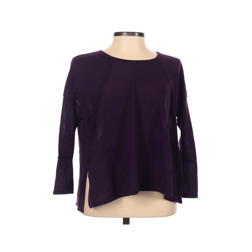

UNTUNED CAPTION: a purple top with long sleeves and a long neckline


TUNED CAPTION: a purple top with long sleeves and a long neckline


DESIRED CAPTION: This is a deep purple, long-sleeved, lightweight women's top with a flowy, asymmetric hem and a relaxed fit, likely made from a soft, stretchy fabric such as jersey or a viscose blend, suitable for



SAMPLE 1:
Hugging Face index: 39


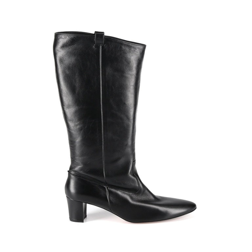

UNTUNED CAPTION: a black leather boot with a pointed toe


TUNED CAPTION: a black leather boot with a pointed toe


DESIRED CAPTION: This is a pair of classic black leather knee-high boots featuring a sleek, fitted silhouette with a pointed toe, mid-height block heel, with a full-length zipper on the shaft, likely from a contemporary era and versatile for various styles



SAMPLE 2:
Hugging Face index: 20


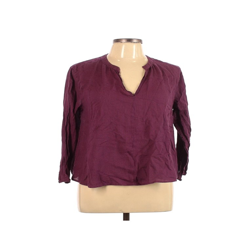

UNTUNED CAPTION: a purple blouse on a mannequin stand


TUNED CAPTION: a purple blouse on a mannequin stand


DESIRED CAPTION: This is a burgundy, long-sleeved, crinkle-textured blouse with a V-neckline and a relaxed fit, likely made from a synthetic blend, indicative of a casual yet stylish contemporary fashion choice.



SAMPLE 3:
Hugging Face index: 16


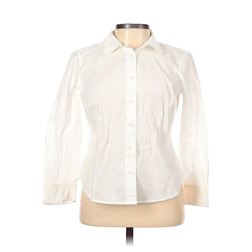

UNTUNED CAPTION: a white shirt on a mannequin stand


TUNED CAPTION: a white shirt on a mannequin stand


DESIRED CAPTION: This is a classic white button-up shirt featuring a crisp collar, long sleeves, and a tailored fit; it's made from a cotton blend fabric, signifying a timeless piece suitable for both business and casual wear.



SAMPLE 4:
Hugging Face index: 35


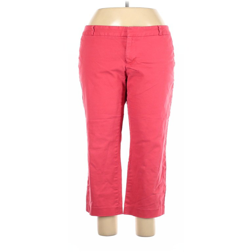

UNTUNED CAPTION: a women's pink pants with a zipper on the side


TUNED CAPTION: a women's pink pants with a zipper on the side


DESIRED CAPTION: These are solid coral-red women's capri pants with a straight-leg cut, likely made from a cotton blend, featuring a mid-rise waist and a classic button-zipper closure, suitable for casual spring/summer wear.



SAMPLE 5:
Hugging Face index: 55


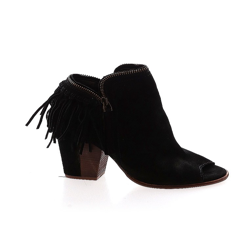

UNTUNED CAPTION: a black boot with fringe detailing on the side


TUNED CAPTION: a black boot with fringe detailing on the side


DESIRED CAPTION: This fashion item is a black ankle boot constructed of suede material, featuring a peep toe, chunky stacked heel, side zipper closure, and embellished with fringe details on the side, invoking a boho-chic style that's



SAMPLE 6:
Hugging Face index: 51


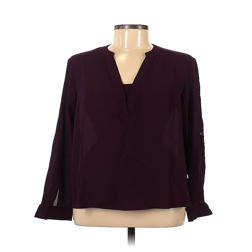

UNTUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


TUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


DESIRED CAPTION: This is a long-sleeved, deep plum blouse featuring a relaxed fit, v-neckline, made from a smooth fabric with a straight hem that falls to hip length, suitable for a contemporary, casual to smart-casual



SAMPLE 7:
Hugging Face index: 26


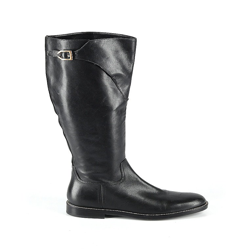

UNTUNED CAPTION: a black leather boot with a buckle on the side


TUNED CAPTION: a black leather boot with a buckle on the side


DESIRED CAPTION: This is a classic black leather knee-high boot featuring a round toe, minimalistic design, flat heel, and a decorative buckle at the top, likely aiming for a versatile, timeless appeal that could fit a variety of looks from casual to semi



SAMPLE 8:
Hugging Face index: 71


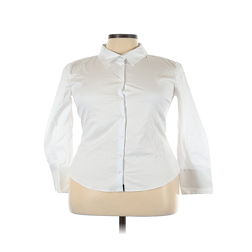

UNTUNED CAPTION: a white shirt on a mannequin stand


TUNED CAPTION: a white shirt on a mannequin stand


DESIRED CAPTION: This is a classic white, button-up blouse with a tailored fit and point collar, made of a smooth, likely cotton-blend fabric, featuring long sleeves with buttoned cuffs, which is versatile for both professional and casual wear



SAMPLE 9:
Hugging Face index: 53


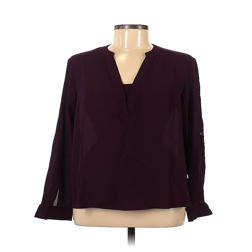

UNTUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


TUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


DESIRED CAPTION: This is a deep plum-colored, long-sleeved blouse with a relaxed fit and a V-neckline, likely made from a lightweight, flowy fabric, evoking a contemporary, casual yet sophisticated style.





In [21]:
dataLoader_to_compare_g = train_dataloader_g
corresponding_hfset = train_hfset_g
MAX_SAMPLES_TO_COMPARE_g = 10
stage_g = 'before'

MAX_SAMPLES_TO_COMPARE_g = min(MAX_SAMPLES_TO_COMPARE_g, BATCH_SIZE_g) #must be less than one batch's worth as currently written
predictions_untuned_g = None

predictions_untuned_g, predictions_tuned_g, labels_g = compareBeforeAndAfter(model_g, processor_g, dataLoader_to_compare_g, corresponding_hfset, stage_g, MAX_SAMPLES_TO_COMPARE_g, predictions_untuned_g)

# Train Model

In [22]:
#Define default values

n_epochs_g = 10

In [23]:
def train_model(model, n_epochs = n_epochs_g, train_dataloader = train_dataloader_g, optimizer = optimizer_g, accelerator = accelerator_g): 
    for epoch in range(n_epochs):
        print(f"{epoch= }")
        
        epoch_accumulated_loss = 0
        nBatches = 0        
            
        model.train()
        for batch in tqdm(train_dataloader): #batch is a dictionary

            optimizer.zero_grad()

            #Get X and y
            tokenized_captions = batch.pop("tokenized_captions")#.to(device) #!!!*** pops instead of indexing to save memory (on old hardware)
            pixel_values = batch.pop("pixel_values").to(torch.float32)

            #Get predictions
            outputs = model(input_ids = tokenized_captions, #input_ids is conventional HF name for tokenized text
                            pixel_values = pixel_values,
                            labels = tokenized_captions)
            
            #Calculate loss and train
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()   
            optimizer.zero_grad()

            epoch_accumulated_loss += loss.item()
            nBatches+=1
    
        print(f"Average Loss: {epoch_accumulated_loss/nBatches}")
        
        print("!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA")        
        # model.eval()
        
        # rouge_score_aggregator = scoring.BootstrapAggregator()
        # bleu_score_aggregator = scoring.BootstrapAggregator()
    
        # for batch in tqdm(validation_dataloader):
    
        #     tokenized_captions = batch.pop("tokenized_captions")#.to(device)
        #     pixel_values = batch.pop("pixel_values").to(torch.float32)
        
        #     predictions = model.generate(pixel_values, max_length = 10)#9 #16 #Here the predictions are text captions written in number encoded words (LUT)
        #     predictions = processor.batch_decode(predictions, skip_special_tokens = True) #now we're in english
        #     labels = processor.batch_decode(tokenized_captions, skip_special_tokens = True) #these are the pre-set captions (decoded from numbers)
    
        #     eval_metric = compute_metrics(predictions, labels) 
        

In [24]:
n_epochs_g = n_epochs_g #Set this to a new number if don't want to use f
train_model(model_g, n_epochs_g)

epoch= 0


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Average Loss: 3.451142350832621
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 1


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Average Loss: 3.3026479880015054
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 2


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Average Loss: 3.0096433560053506
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 3


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Average Loss: 2.78298290570577
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 4


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Average Loss: 2.5848607222239175
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 5


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Average Loss: 2.3865387439727783
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 6


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Average Loss: 2.2172672748565674
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 7


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Average Loss: 2.0937310258547464
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 8


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Average Loss: 2.005170245965322
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA
epoch= 9


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]

Average Loss: 1.932018021742503
!!!***!!! UNCOMMENT VALIDATION CHECK ONCE HAVE VALIDATION DATA


# Look at Before and After

  0%|          | 0/6 [00:00<?, ?it/s]


SAMPLE 0:
Hugging Face index: 21


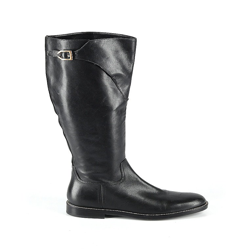

UNTUNED CAPTION: a purple top with long sleeves and a long neckline


TUNED CAPTION: This is a classic black leather knee-high boot featuring a pointed toe, a rounded toe, a pointed heel, and a button closure at the back, making it a versatile style that can be worn for a variety of occasions. It is a classic, timeless style that can be worn with a variety of outfits, including casual wear, business casual, and formal wear. It is a versatile style that can be worn with a variety of outfits, including casual wear, business casual, and formal wear.

DESIRED CAPTION: This is a tall, black leather riding boot featuring a round toe, a flat heel, minimalistic design with a decorative buckle at the top, and a classic, sleek fit, suitable for both equestrian activities and casual fashion.



SAMPLE 1:
Hugging Face index: 55


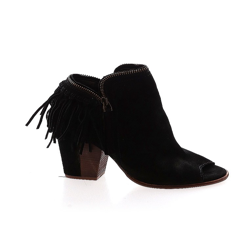

UNTUNED CAPTION: a black leather boot with a pointed toe


TUNED CAPTION: This is a black suede ankle boot featuring a pointed toe, a pointed toe, a block heel, a zipper closure, and a fringe detail at the ankle, likely made from a leather or suede material, likely designed for a casual, casual-yet-stylish look. It is likely a classic style that would be suitable for a variety of occasions, including casual wear, workwear, and evening wear. It is likely a classic style that would be suitable for a variety of occasions,

DESIRED CAPTION: This fashion item is a black ankle boot constructed of suede material, featuring a peep toe, chunky stacked heel, side zipper closure, and embellished with fringe details on the side, invoking a boho-chic style that's



SAMPLE 2:
Hugging Face index: 32


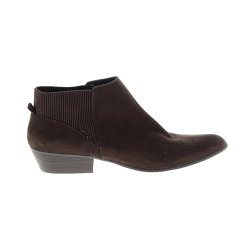

UNTUNED CAPTION: a purple blouse on a mannequin stand


TUNED CAPTION: This is a classic brown suede ankle boot featuring a pointed toe, a rounded toe, a flexible heel, and a pointed toe, making it a versatile style that can be worn with a variety of outfits. It is a classic, timeless style that can be worn with a variety of outfits, including casual, business, and formal. It is a versatile style that can be worn with a variety of outfits, including casual, business, and formal. It is a classic, timeless style that can be

DESIRED CAPTION: This is a contemporary ankle boot featuring a chocolate brown suede upper with elastic side panels for a snug fit, a pointed toe, a small stacked heel, and subtle stitching details, aligned with modern semi-casual footwear styles.



SAMPLE 3:
Hugging Face index: 16


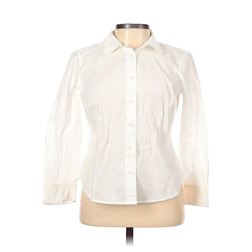

UNTUNED CAPTION: a white shirt on a mannequin stand


TUNED CAPTION: This is a classic, long-sleeved white button-up shirt with a button-down collar, a straight hem, and a relaxed fit, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend

DESIRED CAPTION: This is a classic white button-up shirt featuring a crisp collar, long sleeves, and a tailored fit; it's made from a cotton blend fabric, signifying a timeless piece suitable for both business and casual wear.



SAMPLE 4:
Hugging Face index: 80


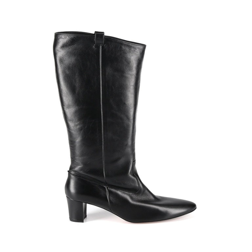

UNTUNED CAPTION: a women's pink pants with a zipper on the side


TUNED CAPTION: This is a classic black leather knee-high boot featuring a pointed toe, a pointed heel, and a pointed toe, designed to fit comfortably over a wide range of sizes, and featuring a pointed toe, a pointed heel, and a pointed toe, suitable for a variety of occasions, including casual wear, workwear, and evening wear. It is a classic style that is timelessly versatile, and is a classic choice for a variety of occasions, including casual wear, workwear, and evening wear

DESIRED CAPTION: This is a classic black leather knee-high boot featuring a tapered toe, a block heel, and a discreet side zipper, reflecting a versatile and timeless style that is likely suitable for both casual and formal occasions.



SAMPLE 5:
Hugging Face index: 81


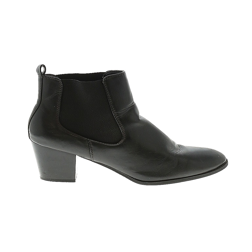

UNTUNED CAPTION: a black boot with fringe detailing on the side


TUNED CAPTION: This is a classic black leather ankle boot featuring a pointed toe, a block heel, a rounded toe, and a pointed toe, suitable for both casual and formal wear, suitable for both men and women, and suitable for both casual and formal wear, suitable for both men and women, and suitable for both casual and formal wear, suitable for both men and women, and suitable for both casual and formal wear, suitable for both men and women, and suitable for both casual and formal wear, suitable for

DESIRED CAPTION: This is a classic black leather Chelsea boot featuring elastic side panels for a snug fit, a modest block heel, a pointed toe silhouette, and a pull tab at the rear for ease of wear, embodying a timeless style that transcends seasons.



SAMPLE 6:
Hugging Face index: 78


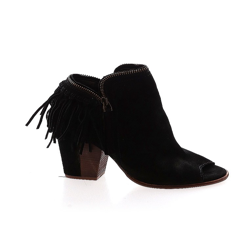

UNTUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


TUNED CAPTION: This is a black suede ankle boot featuring a pointed toe, a pointed toe, a block heel, a zipper closure, and a fringe detail at the ankle, likely made from a leather or suede material, likely designed for a casual, casual-yet-stylish look. It is likely a classic style that would be suitable for a variety of occasions, including casual wear, workwear, and evening wear. It is likely a classic style that would be suitable for a variety of occasions,

DESIRED CAPTION: This is a black suede ankle boot with a peep-toe design, a chunky stacked heel, a side zipper closure, and features a fringe detail that adds a boho-chic touch reminiscent of trends popular in the 2010s



SAMPLE 7:
Hugging Face index: 29


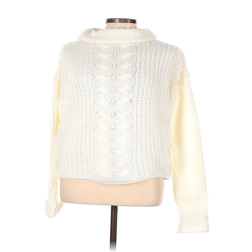

UNTUNED CAPTION: a black leather boot with a buckle on the side


TUNED CAPTION: This is a classic, cream-colored, cable-knit sweater featuring a long, loose-fitting, ribbed knit, featuring a relaxed fit, a relaxed neckline, and a relaxed fit, featuring a classic, cream-colored, cable-knit knit, featuring a long, loose-fitting, ribbed knit, featuring a relaxed fit, a relaxed neckline, and a relaxed fit, featuring a classic, cream-colored, cable-knit, cable-knit sweater featuring a classic,

DESIRED CAPTION: This is an off-white, cozy, cable knit sweater featuring a turtleneck, long sleeves, and a comfortable fit, likely made from a soft yarn possibly including wool or acrylic, evoking a timeless, casual style that's perfect for



SAMPLE 8:
Hugging Face index: 86


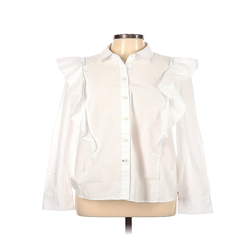

UNTUNED CAPTION: a white shirt on a mannequin stand


TUNED CAPTION: This is a classic white button-up shirt with a long, ruffled collar, a straight hem, and a relaxed fit, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from a cotton blend, likely made from

DESIRED CAPTION: This is a classic, long-sleeved, white button-up shirt made from a likely cotton-blend fabric, featuring a tailored fit with prominent, romantic-style ruffle detailing along the collar and placket, adhering



SAMPLE 9:
Hugging Face index: 18


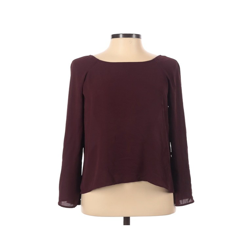

UNTUNED CAPTION: a purple blouse with sheer sleeves and a long sleeve


TUNED CAPTION: This is a burgundy-colored, long-sleeved blouse featuring a relaxed fit, a relaxed fit, and a relaxed fit, likely made from a cotton blend, likely made from a cotton blend, and featuring a relaxed fit, likely made from a cotton blend, and featuring a relaxed fit, likely made from a cotton blend, and featuring a relaxed fit, likely made from a cotton blend, and featuring a relaxed fit, likely made from a cotton blend, and featuring a relaxed fit

DESIRED CAPTION: This is a burgundy women's blouse with a relaxed fit, made from a smooth, lightweight fabric, featuring long sleeves with potential lace embellishments at the cuffs, a round neckline, and a high-low hem, suggesting





(['a purple top with long sleeves and a long neckline\n',
  'a black leather boot with a pointed toe\n',
  'a purple blouse on a mannequin stand\n',
  'a white shirt on a mannequin stand\n',
  "a women's pink pants with a zipper on the side\n",
  'a black boot with fringe detailing on the side\n',
  'a purple blouse with sheer sleeves and a long sleeve\n',
  'a black leather boot with a buckle on the side\n',
  'a white shirt on a mannequin stand\n',
  'a purple blouse with sheer sleeves and a long sleeve\n'],
 ['This is a classic black leather knee-high boot featuring a pointed toe, a rounded toe, a pointed heel, and a button closure at the back, making it a versatile style that can be worn for a variety of occasions. It is a classic, timeless style that can be worn with a variety of outfits, including casual wear, business casual, and formal wear. It is a versatile style that can be worn with a variety of outfits, including casual wear, business casual, and formal wear.',
  'This is 

In [25]:
stage_g = 'after'
compareBeforeAndAfter(model_g, processor_g, dataLoader_to_compare_g, corresponding_hfset, stage_g, MAX_SAMPLES_TO_COMPARE_g, predictions_untuned_g)



In [ ]:
commit_note = "Created fashion_image_captioner that finetunes pretrained visual language model on fashion images with captions"

if True:
    !git add fashion_image_captioner
    !git commit -m "{commit_note}"
    !git push -u origin master